# Lab 0
## Overview
1. Read in HPGe spectra from file
1. Inspect spectra
1. Perform energy calibration
    - Identify prominent lines for each source type within spectra
    - Find mean value of these lines using fitting techniques
    - Create a linear relationship between channels and energies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.rcParams['figure.figsize'] = (9,6)
plt.style.use('../style.mplstyle')

## 1. Read in prepared data

In [2]:
ls ../data

lab0_spectral_data.md5  lab0_spectral_data.txt


Read in the spectra to a `pandas DataFrame`

In [3]:
spectra = pd.read_table('../data/lab0_spectral_data.txt', header=0, delim_whitespace=True, escapechar='#')

Take a look at the first few bins:

In [4]:
spectra.head(20)

,Am-241,Ba-133,Cs-137,Co-60,Eu-152
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,0,0,0,0,0


In [5]:
spectra.columns

Index([' Am-241', 'Ba-133', 'Cs-137', 'Co-60', 'Eu-152'], dtype='object')

The first source name has an extra space in front of it... Let's remove it:

In [6]:
spectra.rename(columns={' Am-241':'Am-241'}, inplace=True)

## 2. Inspect spectra
Let's take a look at all spectra on a single plot:

In [7]:
FIGDIR = '../fig/'
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

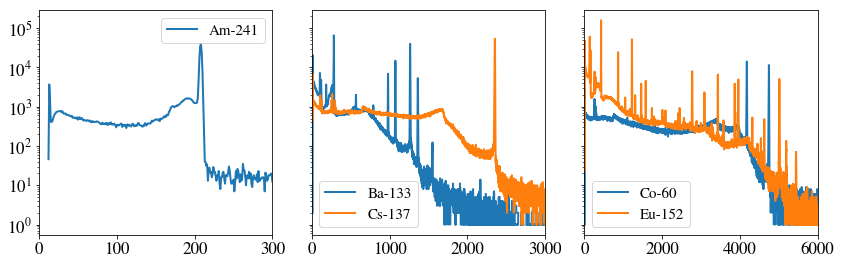

In [8]:
f, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

spectra[['Am-241']].plot(ax=ax[0])
spectra[['Ba-133', 'Cs-137']].plot(ax=ax[1])
spectra[['Co-60', 'Eu-152']].plot(ax=ax[2])


ax[0].set_xlim(0, 300)
ax[1].set_xlim(0, 3000)
ax[2].set_xlim(0, 6000)

ax[0].set_yscale('log')

plt.tight_layout()
f.savefig(f'{FIGDIR}spectra.eps', format='eps')
plt.show()

## 3. Identify peaks and find mean values of each
Using data for the given sources, there are a number of prominent lines we should try to identify, shown in the table below.
## Lines of Interest
| Source        | Energy (kev)  |
| ------------- |:-------------:|
| $^{241}$Am    | 59.5          |
| $^{133}$Ba    | 80.997        |
|               | 356.017       |
| $^{60}$Co     | 1173.2        |
|               | 1332.5        |
| $^{137}$Cs    | 661.6         |
| $^{152}$Eu    | 121.8         |
|               | 344.3         |
|               | 1408.0        |

For each source, we note one or more gamma-ray lines of interest and determine the associated MCA channel. Let's store all of these in a source DataFrame:

In [9]:
lines = pd.DataFrame(columns=['src', 'energy', 'channel'])

In [10]:
def append_row(df, src, energy, popt):
    """Add a line to a DataFrame
    """
    data = df.copy()
    data = data.append({'src' : src,
                        'energy' : energy,
                        'channel' : np.round(popt[1]).astype(int)},
                        ignore_index=True)
    # Below is due to the channel number being converted to an object for some reason...
    data['channel'] = data['channel'].apply(pd.to_numeric)
    
    return data

### $^{137}$Cs

In [11]:
f, ax = plt.subplots()
spectra['Cs-137'].plot(ax=ax)
ax.semilogy()
ax.set_xlim(2330, 2375);

We see a maximum at around 2360, so let's consider a window around this. In particular, let's fit a Gaussian over the window $[2340, 2365]$. The script `scripts/fitting.py` contains a routine for fitting a gaussian function over some window.

To load these, we need to add our module directory to `PATH`:

In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
from fitting import gaussian, fit_gaus_window

Now let's fit this peak:

In [14]:
cs137_662_popt, _ = fit_gaus_window(spectra['Cs-137'], 2340, 2365, p0=[4e+4, 2354, 5])

We can then relate the 662 keV line of $^{137}$Cs to the channel below:

In [15]:
lines = append_row(lines, 'Cs-137', 661.657, cs137_662_popt)

### $^{241}$Am

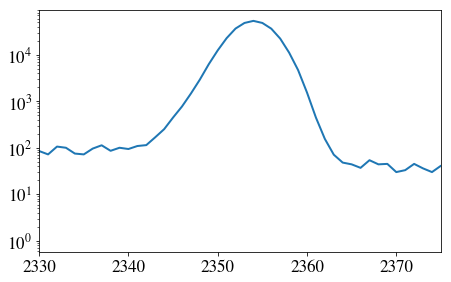

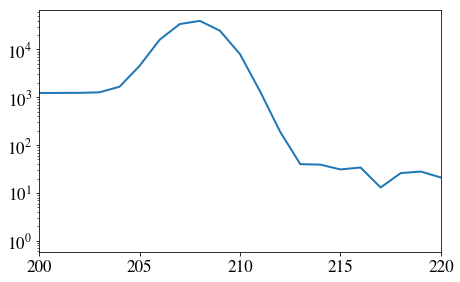

In [16]:
f, ax = plt.subplots()

spectra['Am-241'].plot(ax=ax)
ax.semilogy()
ax.set_xlim(200, 220);
plt.show()

In [17]:
am241_popt, _ = fit_gaus_window(spectra['Am-241'], 202, 212, p0=[3e+4, 205, 5])

In [18]:
lines = append_row(lines, 'Am-241', 59.541, am241_popt)

### $^{133}$Ba

Fit the low-energy line of Ba:

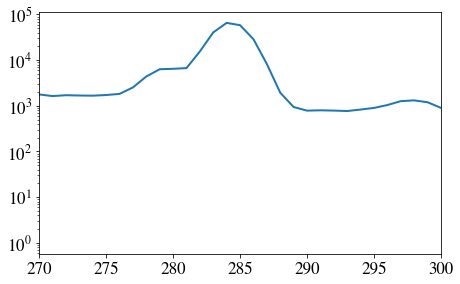

In [19]:
f, ax = plt.subplots()

spectra['Ba-133'].plot(ax=ax)
ax.semilogy()
plt.xlim(270, 300)
plt.show()

In [20]:
ba133_80_popt, _ = fit_gaus_window(spectra['Ba-133'], 280, 290, p0=[6e+4, 285, 2])

In [21]:
lines = append_row(lines, 'Ba-133', 80.997, ba133_80_popt)

Fit the higher energy line:

In [22]:
ba133_356_popt, _ = fit_gaus_window(spectra['Ba-133'], 1250, 1280, p0=[1e+4, 1260, 2])

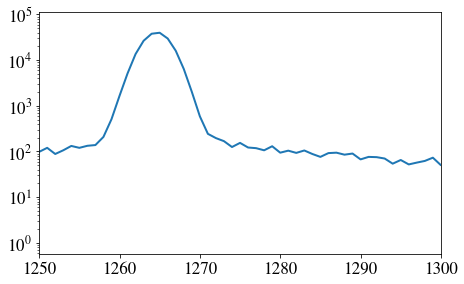

In [23]:
f, ax = plt.subplots()

spectra['Ba-133'].plot(ax=ax)
ax.semilogy()
plt.xlim(1250, 1300)
plt.show()

In [24]:
lines = append_row(lines, 'Ba-133', 356.017, ba133_356_popt)

### $^{60}$Co

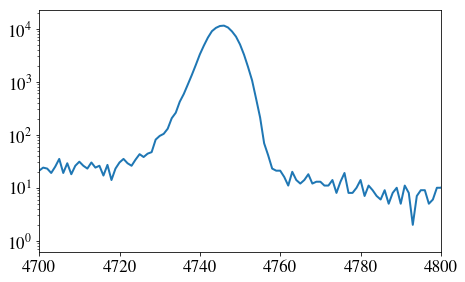

In [25]:
f, ax = plt.subplots()

spectra['Co-60'].plot(ax=ax)
ax.semilogy()
plt.xlim(4700, 4800)
plt.show()

Add the 1173 keV line:

In [26]:
co60_1173_popt, _ = fit_gaus_window(spectra['Co-60'], 4170, 4190, p0=[1e+4, 4180, 20])

In [27]:
lines = append_row(lines, 'Co-60', 1173.237, co60_1173_popt)

Add the 1332 keV line:

In [28]:
co60_1332_popt, _ = fit_gaus_window(spectra['Co-60'], 4720, 4760, p0=[1e+4, 4750, 20])

In [29]:
lines = append_row(lines, 'Co-60', 1332.501, co60_1332_popt)

### $^{152}$Eu

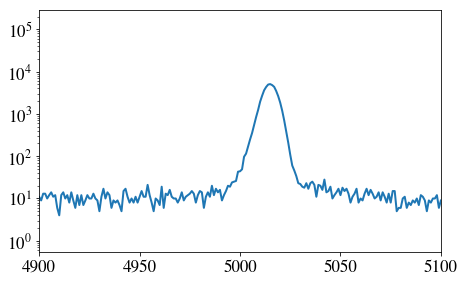

In [30]:
f, ax = plt.subplots()

spectra['Eu-152'].plot(ax=ax)
ax.semilogy()
plt.xlim(4900, 5100)
plt.show()

Add the 122 keV line:

In [31]:
eu152_122_popt, _ = fit_gaus_window(spectra['Eu-152'], 420, 440, p0=[1e+5, 425, 5])

In [32]:
lines = append_row(lines, 'Eu-152', 121.781, eu152_122_popt)

Add the 2408 keV line:

In [33]:
eu152_1408_popt, _ = fit_gaus_window(spectra['Eu-152'], 5000, 5025, p0=[1e+4, 5010, 15])

In [34]:
lines = append_row(lines, 'Eu-152', 1408.006, eu152_1408_popt)

In [35]:
lines

,src,energy,channel
0,Cs-137,661.657,2354
1,Am-241,59.541,208
2,Ba-133,80.997,284
3,Ba-133,356.017,1265
4,Co-60,1173.237,4178
5,Co-60,1332.501,4746
6,Eu-152,121.781,430
7,Eu-152,1408.006,5015


## 4. Perform calibrations
We will account for nonlinearities by considering a polynomial function to fit our data. In particular, we will consider fits in the form

$$E_i = \sum_{j=0}^{N} a_j C_i^j$$

Where $E_i$ is the energy associated with the line with peak ADC value $C_i$. By creating a fit based on gamma-ray lines from a number of sources and then evaluating the fit on a separate set of gamma-ray lines, we can determine an appropriate value for our hyperparameter $N$.

In [36]:
from fitting import generate_X, lstsq, lstsq_err

First, let's take a look at the relationship between channel number and energy:

In [37]:
lines.sort_values('channel', inplace=True)
lines.reset_index(inplace=True)
del lines['index']

That looks pretty linear, but let's go ahead and fits out for a number of different model orders.

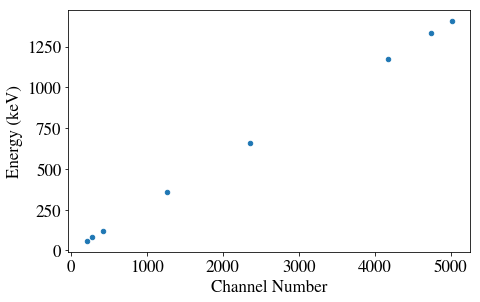

In [38]:
f, ax = plt.subplots()
lines.plot(x='channel', y='energy', kind='scatter', ax=ax)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Energy (keV)')
plt.show()

Fit a two-point model using Cs and Am:

In [39]:
two_point_data = lines[(lines['src'] == 'Cs-137') | (lines['src'] == 'Am-241')]

In [40]:
two_point_data

,src,energy,channel
0,Am-241,59.541,208
4,Cs-137,661.657,2354


In [41]:
two_point_features = generate_X(two_point_data.channel, 1)
two_point_weights = lstsq(two_point_features, two_point_data['energy'].values)

In [42]:
two_point_weights

array([ 1.1812013 ,  0.28057596])

In [43]:
two_point_features @ two_point_weights

array([  59.541,  661.657])

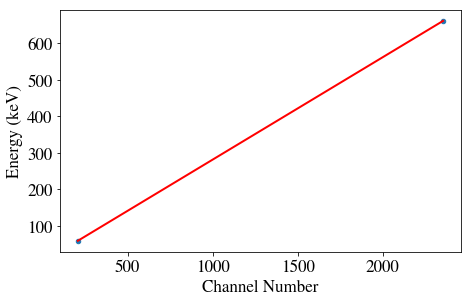

In [44]:
f, ax = plt.subplots()
two_point_data.plot(x='channel', y='energy', kind='scatter', ax=ax)
ax.plot(two_point_data.channel, two_point_features @ two_point_weights, c='r')
ax.set_xlabel('Channel Number')
ax.set_ylabel('Energy (keV)')
plt.show()

Evaluate the fit using other known values. Take our measured bins and 

In [45]:
two_point_ba_est = two_point_weights[0] + lines[lines['src'] == 'Ba-133']['channel'] * two_point_weights[1]

In [46]:
(lines[lines['src'] == 'Ba-133']['energy'] - two_point_ba_est) / lines[lines['src'] == 'Ba-133']['energy']

1    0.001632
3   -0.000261
dtype: float64

### Fitting with a nonlinear function

In [47]:
# Choose a maximum model order
n = 6

# Define a vector to hold the error
err_train = np.zeros(n-1)

for idx in range(1, n):
    X = generate_X(lines['channel'].values, idx)
    w = lstsq(X, lines['energy'].values)
    err_train[idx-1] = lstsq_err(X, lines['energy'].values, w)

Let's visualize how our error decreases as we increase the model order:

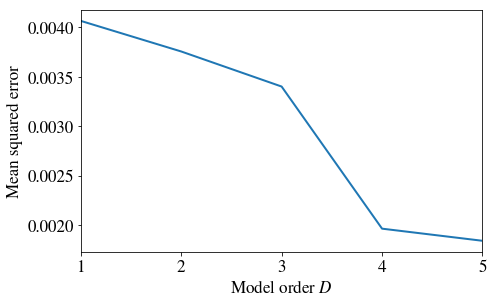

In [48]:
f, ax = plt.subplots()

ax.plot(np.arange(1, n), err_train)
ax.set_xlabel('Model order $D$')
ax.set_xlim(1, n-1)
ax.set_xticks(np.arange(1, n, 1))
ax.set_ylabel('Mean squared error');
f.savefig(f'{FIGDIR}mse.eps')
plt.show()

As expected, we will decrease our model order as we make it more complicated, but what are the order of our weights?

In [49]:
w

array([  1.29598875e+00,   2.80283874e-01,   2.93775583e-10,
         1.30774410e-10,  -4.80102817e-14,   4.71366005e-18])

We see that the model coefficients get very small for high order models. With more lines, we could choose a model order based on a model that best describes lines that were not used in fitting, but that's probably overkill here. Instead, we can arbitrarily choose a third order model. Since the weights are on the order of $10^{-8}$, this would result in a correction of about $10^{-5}$ at around 1 MeV.

Instead of a complicated nonlinear fit, let's just use a two-parameter linear model.

In [50]:
X = generate_X(lines['channel'].values, 1)
w = lstsq(X, lines['energy'].values)

Let's plot this fit over our original data points:

In [51]:
w

array([ 1.23082206,  0.28051355])

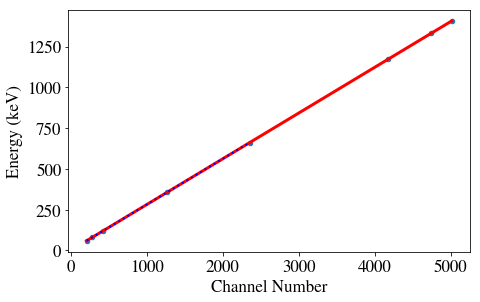

In [52]:
f, ax = plt.subplots()
lines.plot(x='channel', y='energy', kind='scatter', ax=ax)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Energy (keV)')
ax.plot((lines['channel']), X @ w, c='r', lw=3)
ax.plot(two_point_data['channel'], two_point_features @ two_point_weights, c='b', ls=':')
f.savefig(f'{FIGDIR}calibration_fit.eps');
plt.show()